In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
from sklearn.model_selection import KFold
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Plotting function
from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunKeras import NaiveBayes as nb
from RunKeras import PrepareBehaviorData as pbd

nb = nb()
m = ModelPredictionPlots()

Using TensorFlow backend.


Validation functions


## Get Data for training and testing

In [3]:
task_dict = {'Task1':'1 Fam Rew', 
             'Task2':'2 No Rew', 
             'Task3':'3 Fam Rew', 
             'Task4':'4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR14/'

frame_lick_stop = 5154
task_numframes = {'Task1': 15000, 
                  'Task2': 20000, 
                  'Task3': 20000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [5]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [6]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task2 is 134
Number of PlaceCells in Task1 is 126
Number of PlaceCells in Task4 is 126
Number of PlaceCells in Task3 is 91


In [22]:
# Get Xdata - calcium data and Ydata - running behavior
X = A.Fc3data_dict['Task1'][:, A.Parsed_Behavior['good_running_index'].item()['Task1']].T[:-1, :]
Y = A.Parsed_Behavior['good_running_data'].item()['Task1'][:-1]
print(np.shape(X), np.shape(Y))

(6920, 378) (6920, 1)


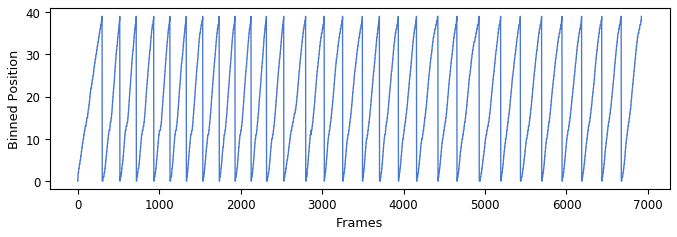

In [23]:
B = pbd(BehaviorData=Y, tracklength=tracklength, trackbins=trackbins)
y_cat = B.position_binary

In [24]:
#Split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.10, random_state=None, shuffle=False)
print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(6228, 378) (692, 378) (6228,) (692,)


### Run Naive Bayes


Accuracy of test set:: 0.38%


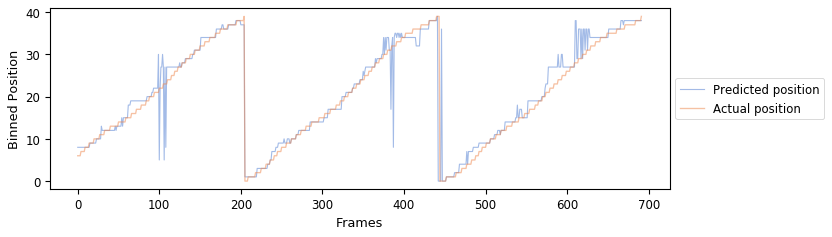

In [25]:
gaussianNB = nb.fit_naivebayes(X_train, y_train)
scores, y_predicted, y_errorprob = nb.validate_model(gaussianNB, X_test, y_test)

In [26]:
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' %R2)
print(f'rho: %.2f' %rho)

R2: 0.91
rho: 0.96


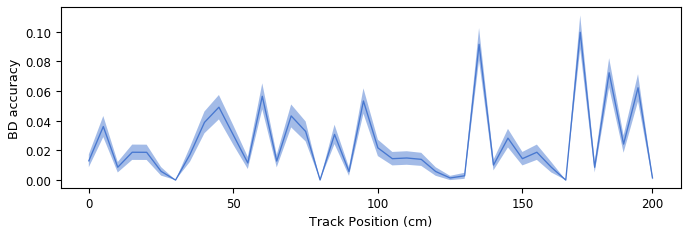

In [27]:
nb.plot_error_probability(y_errorprob)

In [28]:
np.savez(os.path.join(SaveResults, 'FinalBayesFit.npz'),
         X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
         R2=R2, rho=rho, y_predicted=y_predicted, y_probability=y_errorprob)

### K-fold validation of model

In [43]:
from sklearn.model_selection import KFold

In [44]:
#Define k-fold validation
k = KFold(n_splits=10, random_state=None, shuffle=False)

Performing 10-fold validation
Validation 1
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.08%


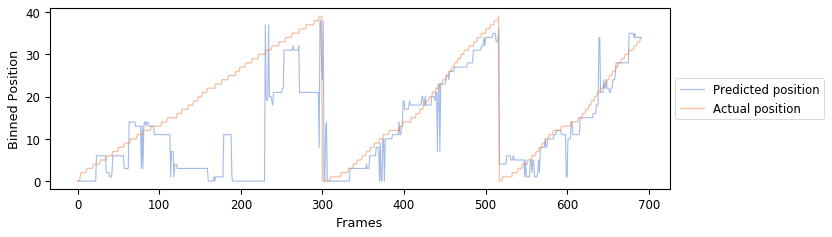

Validation 2
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.23%


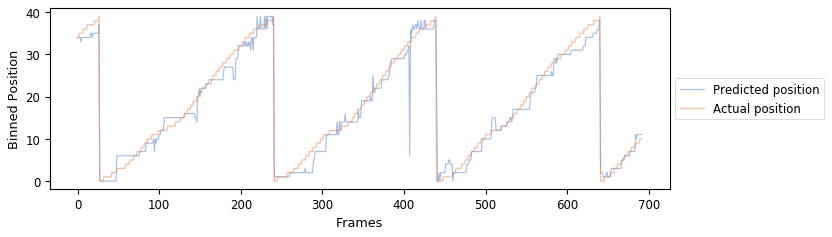

Validation 3
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.33%


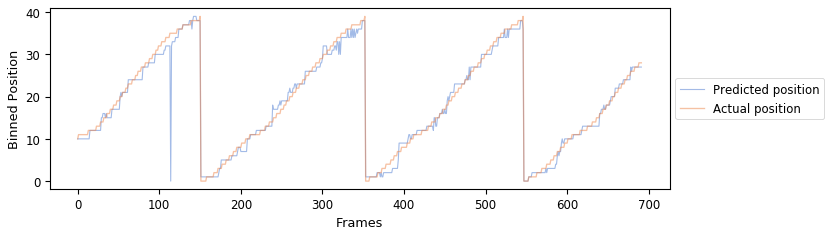

Validation 4
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.24%


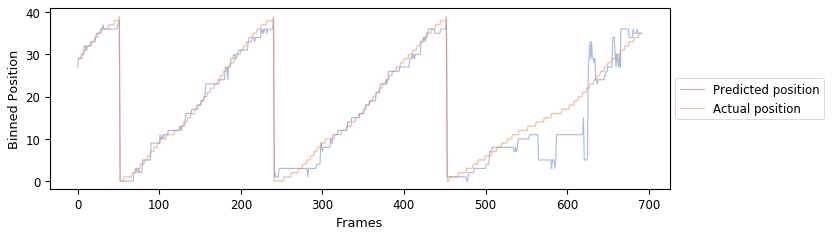

Validation 5
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.24%


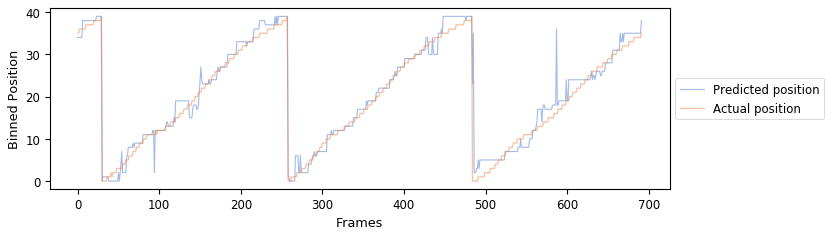

Validation 6
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.31%


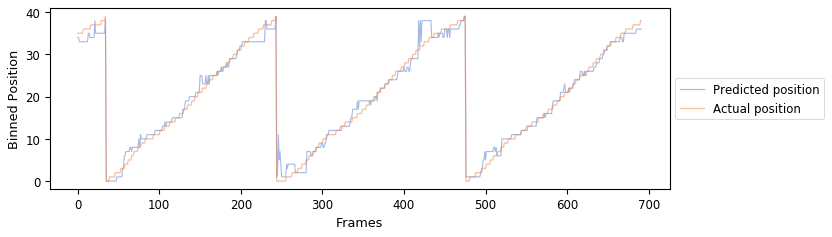

Validation 7
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.35%


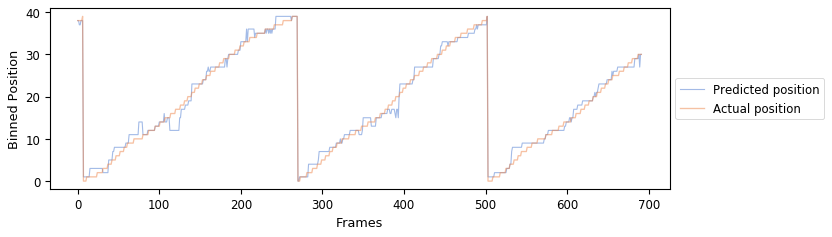

Validation 8
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.28%


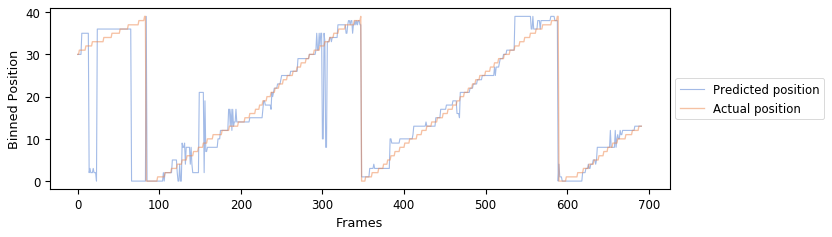

Validation 9
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.38%


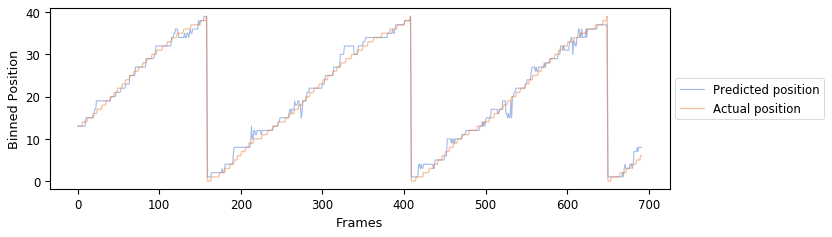

Validation 10
(6228, 378) (6228,) (692, 378) (692,)

Accuracy of test set:: 0.38%


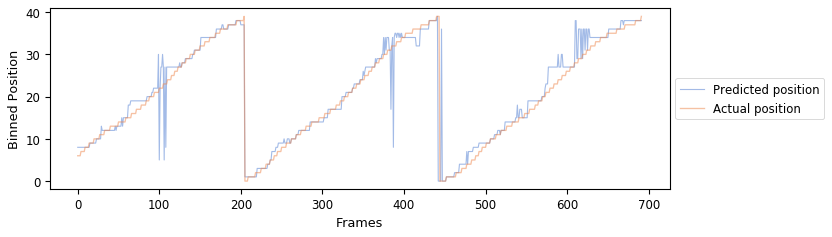

In [45]:
print(f'Performing %d-fold validation' % k.n_splits)
count_cv = 1
nbcv_dataframe = pd.DataFrame(
    columns=['CVIndex', 'ModelAccuracy', 'Y_test', 'Y_predict', 'Y_diff', 'mean_errorprob', 'sem_errorprob'])
for train_index, test_index in k.split(X):
    print(f'Validation %d' % count_cv)
    xcv_train, xcv_test = X[train_index], X[test_index]
    ycv_train, ycv_test = y_cat[train_index], y_cat[test_index]

    print(np.shape(xcv_train), np.shape(ycv_train),
          np.shape(xcv_test), np.shape(ycv_test))
    cvsnbmodel = nb.fit_naivebayes(xcv_train, ycv_train)

    # evaluate the model and save evalautions
    scores, ycv_predict, ycv_probability = nb.validate_model(
        cvsnbmodel, xcv_test, ycv_test)
    nbcv_dataframe = nbcv_dataframe.append({'CVIndex': count_cv,
                                            'ModelAccuracy': scores,
                                            'Y_test': ycv_test,
                                            'Y_predict': ycv_predict,
                                            'Y_diff': np.abs(ycv_test-ycv_predict),
                                            'mean_errorprob': np.mean(ycv_probability, 0),
                                            'sem_errorprob': scipy.stats.sem(ycv_probability, 0)}, 
                                            ignore_index=True)
    count_cv += 1

Validation functions
R2: 0.85 +/- 0.242772
Rho: 0.94 +/- 0.096469


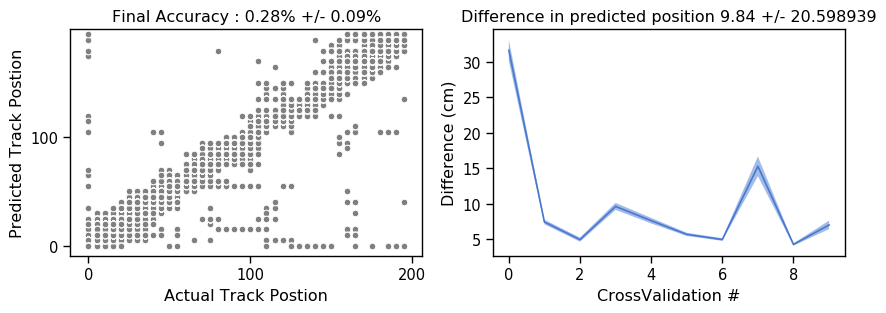

In [46]:
m = ModelPredictionPlots()
m.PlotCVResult(cv_dataframe=nbcv_dataframe, trackbins=trackbins, numsplits=k.n_splits)

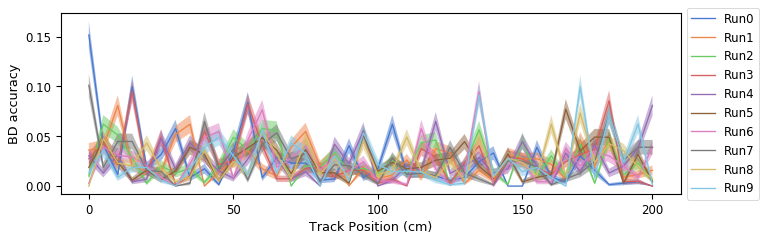

In [47]:
m.plot_bayes_probability(nbcv_dataframe)

In [48]:
#Save CSV
nbcv_dataframe.to_pickle(os.path.join(SaveResults, f'%d-foldevaluation.pkl'%k.n_splits))

### Get accuracy with number of cells

#### With all cells

In [35]:
numsamples, R2_numcells_dict_cntrl, rho_numcells_dict_cntrl = nb.decoderaccuracy_wtih_numcells(X_data=X, Y_data=y_cat, iterations=100)

Validation functions
Fitting on 37 neurons

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.21%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.18%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.22%

Accuracy of test set:: 0.20%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.22%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.1


Accuracy of test set:: 0.38%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.30%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.25%

Accuracy of test set:: 0.34%

Accuracy of test set:: 0.30%

Accuracy of test set:: 0.37%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.25%

Accuracy of test set:: 0.34%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.22%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.35%

Accuracy of test set:: 0.34%

Accuracy of test set:: 0.34%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.24%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.22%

Accuracy of test set:: 0.30%

Accuracy of test set:: 0.33%

Accuracy of test set:: 0.26%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.22%

Accuracy of test set:: 0.22%
Fitting on 302 neurons

Accuracy of test set:: 0.36%

Accuracy of test set:: 0.36%

Accuracy of test set:: 0.38%

Accuracy of test set:: 0.39%

Accuracy of test

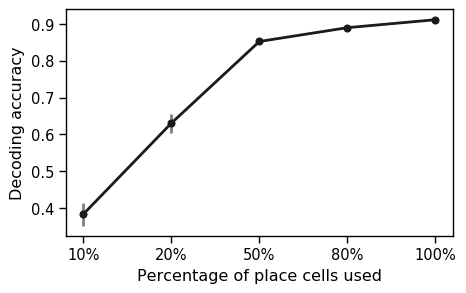

In [36]:
mean_R2_cntrl, sem_R2_cntrl = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_cntrl, numsamples)

#### With only place cells

In [37]:
X_pfs = X[:, A.sig_PFs_cellnum_dict['Task1']]
print(np.shape(X_pfs))
numsamples, R2_numcells_dict_cntrl_pfs, rho_numcells_dict_cntrl_pfs = nb.decoderaccuracy_wtih_numcells(X_data=X_pfs, Y_data=y_cat, iterations=100)

(6920, 126)
Validation functions
Fitting on 12 neurons

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.22%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.18%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.22%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.20%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.20%

Accuracy of test set:: 0.18%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.15%

Accuracy of te


Accuracy of test set:: 0.34%

Accuracy of test set:: 0.36%

Accuracy of test set:: 0.32%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.32%

Accuracy of test set:: 0.33%

Accuracy of test set:: 0.35%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.35%

Accuracy of test set:: 0.24%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.35%

Accuracy of test set:: 0.34%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.33%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.32%

Accuracy of test set:: 0.32%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.30%

Accuracy of test set:: 0.33%

Accuracy of test set:: 0.34%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.30%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.25%
Fitting on 100 neurons

Accuracy of test set:: 0.37%

Accuracy of test set:: 0.36%

Accuracy of test set:: 0.37%

Accuracy of test set:: 0.36%

Accuracy of test

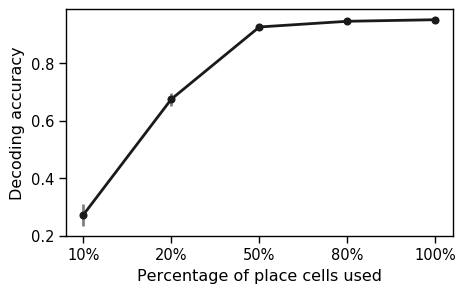

In [38]:
mean_R2_cntrl_pfs, sem_R2_cntrl_pfs = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_cntrl_pfs, numsamples)

#### Without place cells

In [39]:
pfs = A.sig_PFs_cellnum_dict['Task1']
temp_shape = np.arange(X.shape[1])
notpfs = np.setxor1d(temp_shape, pfs)
X_notpfs = X[:, notpfs]
print(np.shape(X_notpfs))

(6920, 252)


In [40]:
numsamples, R2_numcells_dict_cntrl_notpfs, rho_numcells_dict_cntrl_notpfs = nb.decoderaccuracy_wtih_numcells(X_data=X_notpfs, Y_data=y_cat, iterations=100)

Validation functions
Fitting on 25 neurons

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.06%

Accuracy of test set:: 0.02%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.06%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.06%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.06%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.06%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.0


Accuracy of test set:: 0.16%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.20%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.18%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.18%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.15%
Fitting on 201 neurons

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.20%

Accuracy of test set:: 0.18%

Accuracy of test

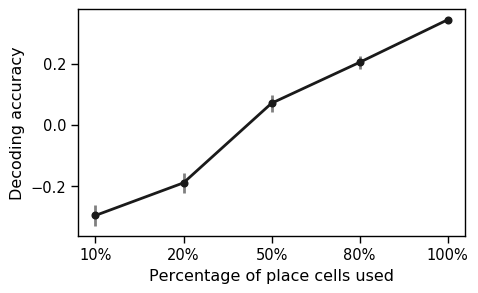

In [41]:
mean_R2_cntrl_notpfs, sem_R2_cntrl_notpfs = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_cntrl_notpfs, numsamples)

#### Plot all together

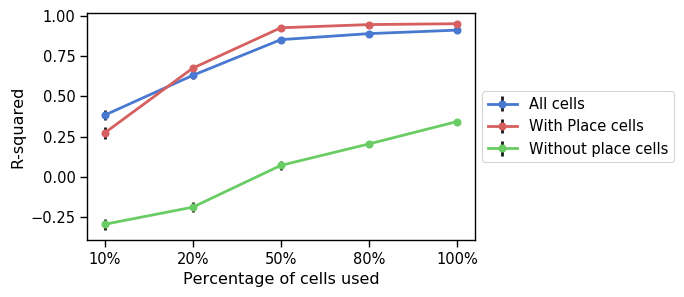

In [42]:
plt.figure(figsize=(5, 3), dpi=100)
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_cntrl, yerr=sem_R2_cntrl, color='b', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='All cells')
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_cntrl_pfs, yerr=sem_R2_cntrl_pfs, color='r', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='With Place cells')
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_cntrl_notpfs, yerr=sem_R2_cntrl_notpfs, color='g', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='Without place cells')
plt.xticks(np.arange(np.size(numsamples)), ['10%', '20%', '50%', '80%', '100%'])
plt.xlabel('Percentage of cells used')
plt.ylabel('R-squared');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))